In [1]:
import numpy as np
import stim

import majority_vote_tree_code_helper as tree_code_helper
from rgs_config import Node, Pauli, RgsConfig
from rgs_theoretical_model import prob_rgs_trial

### Checkpoints

- apply loss to every photons?
- track every side effects 
    - every time there's a measurement occurs
    - photons (excluding last level) from push-out of emitters
    - photons (first-level only) from the joining outer with inner qubits
    - anchor emitter from joining outer with inner qubits
    - recap
        - inner photons (non first/non last): from generations
        - inner photons first-level: from outer/inner join
        - inner photons first-level: from two halves joining
        - outer photons: from joining inner/outer (also track the H)
        - anchor: outer/inner join

In [2]:
def helper_apply_photon_loss_and_channel_error(conf: RgsConfig, photon: int) -> bool:
    """returns a bool indicating whether or not the qubit is lost"""
    conf.total_photons += 1

    # apply depolarizing channel
    conf.t.depolarize1(photon, p=conf.error_probability)

    if conf.rng.random() >= conf.loss_probability:
        return False
    conf.lost_photons += 1
    conf.t.x_error(photon, p=0.5)
    conf.t.z_error(photon, p=0.5)  # type: ignore
    return True


def helper_update_eigenvalue_with_side_effect(conf: RgsConfig):

    def __update_eigenvalue_with_side_effect_recurse(root: Node):
        if (not root.is_lost) and (root.measurement_basis == Pauli.X) and (root.has_z):
            root.eigenvalue = not root.eigenvalue
        for v in root.children:
            __update_eigenvalue_with_side_effect_recurse(v)

    for meas_tree in conf.measurement_trees:
        for root in meas_tree:
            __update_eigenvalue_with_side_effect_recurse(root)


def helper_decode_logical_result(conf: RgsConfig) -> bool:
    """decode logical qubit from all measurements (all info stored in config)
    and returns a boolean indicating whether all inner qubits can be decoded or not"""
    for i, meas_tree in enumerate(conf.measurement_trees):
        x_decode_count = 0
        z_decode_count = 0
        for arm, root in enumerate(meas_tree):
            if conf.succeeded_bsm_arm_indices[i // 2] == arm:
                x_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_x(root)
            else:
                z_decode_count += 1
                conf.logical_results[i][arm] = tree_code_helper.decode_tree_logical_z(root)
    return all([m is not None for arms in conf.logical_results for m in arms])

### General Idea of how to optimize the simulation

1. We keep the required qubits in the system at a time to the minimum, i.e., minimum emitters and photons.
    1. we simulate hop-by-hop fashion, creating two half-RGSs, and the action at the ABSA between them.
    2. Beyond the first hop, the Bell pairs created thus far are stored in two memories between two nodes (thus 2 memories here)
    3. The next hop, creating by another set of emitters and at most 2 photons at a time (2 anchors; 2 outer emitters; 2 photons; one set of inner qubit emitters |bv|)

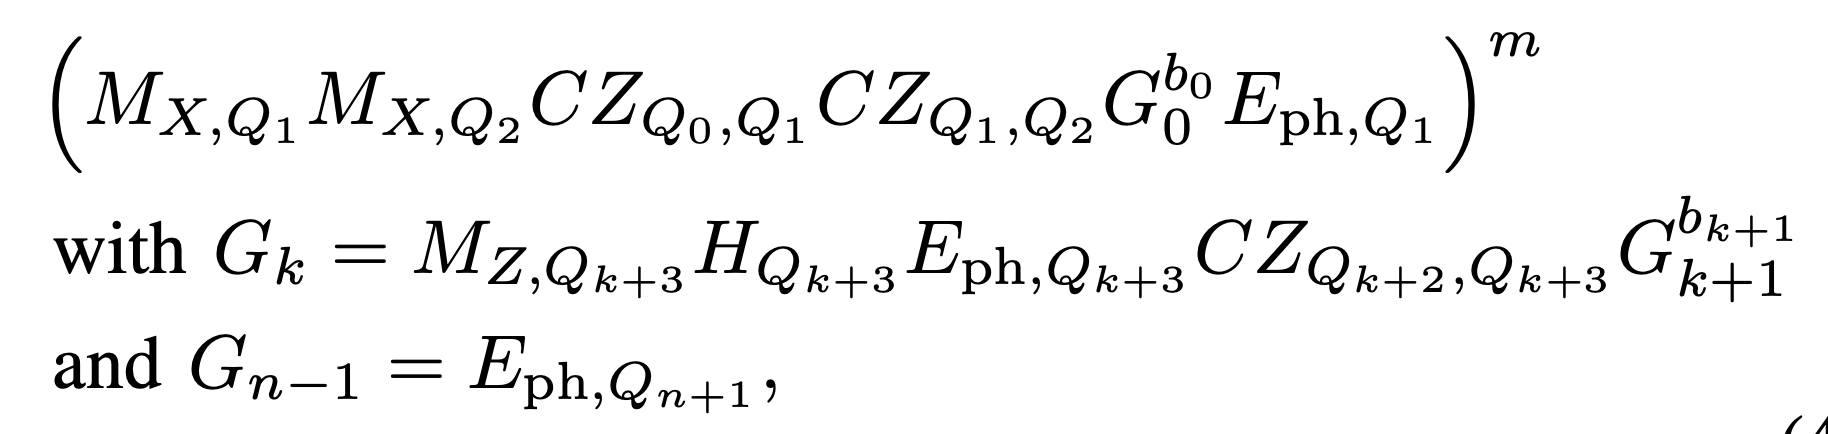

In [3]:
def generate_and_measure_inner_qubit(conf: RgsConfig, logical_basis: Pauli, root: Node):
    """Generate and measure an inner logical qubit, which comprises of lots of physical qubits."""

    # specifying the basis (i.e., X or Z) will be measured in the odd level while even will be the other basis (i.e., Z or X)
    # this is opposite of what we wrote in the paper since we count the level of the tree from 0 (in the paper we count from 1)
    even_basis = logical_basis
    if even_basis == Pauli.X:
        odd_basis = Pauli.Z
    else:
        odd_basis = Pauli.X
    n = len(conf.bv)

    # postorder lists
    postorder_measurement_bases: list[Pauli | None] = []
    postorder_measurement_results: list[bool | None] = []
    postorder_photon_lost: list[bool] = []
    postorder_side_effects: list[bool] = []

    # short hand
    t = conf.t
    photon = conf.photon
    emitters = conf.emitters

    def __recurse_generate_and_measure(i):
        # one call generates one child (subtree) of emitter i-th
        # from having (j, b_{i+1}, b{i+2}, ..., b_{n-1}) to (j + 1, b_{i+1}, b{i+2}, ..., b_{n-1})
        # initially, j is 0 for the first call
        # we assume that the emitters are always in the |+> state,
        # so we need to reinitialize it every time we perform measurements on an emitter.
        basis = odd_basis if i % 2 == 1 else even_basis
        if i == n - 1:
            # generation part: G_{n-1}
            t.reset(photon)
            t.cx(emitters[i], photon)
            t.h(photon)  # to fix up the H side effect

            # measurement part
            if helper_apply_photon_loss_and_channel_error(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
                postorder_side_effects.append(False)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))
                postorder_side_effects.append(False)
        else:
            # generation part: G_k
            for _ in range(conf.bv[i + 1]):
                # G_{i+1} ^ (b_{i+1}); this is anchored at emitter[i+1]
                __recurse_generate_and_measure(i + 1)
            t.cz(emitters[i], emitters[i + 1])
            t.reset(photon)
            t.cx(emitters[i + 1], photon)
            t.h(emitters[i + 1])
            postorder_side_effects.append(t.measure(emitters[i + 1]))
            t.reset_x(emitters[i + 1])  # reinitialize emitter q_{i+1}

            # measure the newly created photon at level k
            if helper_apply_photon_loss_and_channel_error(conf, photon):
                postorder_photon_lost.append(True)
                postorder_measurement_bases.append(None)
                postorder_measurement_results.append(None)
            else:
                if basis == Pauli.X:
                    t.h(photon)
                postorder_photon_lost.append(False)
                postorder_measurement_bases.append(basis)
                postorder_measurement_results.append(t.measure(photon))

    for _ in range(conf.bv[0]):
        __recurse_generate_and_measure(0)

    postorder_nodes = root.get_postorder_traversal()

    # we don't need the last entry since it is the outer photon
    for i, u in enumerate(postorder_nodes[:-1]):
        u.has_z = postorder_side_effects[i]
        u.measurement_result = u.eigenvalue = postorder_measurement_results[i]
        u.measurement_basis = postorder_measurement_bases[i]
        u.is_lost = postorder_photon_lost[i]

In [4]:
def rgs_protocol_helper_one_hop(conf: RgsConfig, left_anchor: int, right_anchor: int, hop_index: int) -> bool:
    """This function process one hop of the loss-only RGS trial with the two qubit anchors are provided via `left_anchor` and `right_anchor`.
    Returns whether the BSM of outer qubits are successful or not, so the simulation can stop early"""

    """In here, we streamline the previous version by generating one photon at a time (two for BSM). Most of the complexity of the optimized version lies here.
    This function does the following.
    --------------------------------
    """
    t = conf.t
    left_outer_emitter = conf.outer_emitter_left
    right_outer_emitter = conf.outer_emitter_right
    left_photon = conf.photon_left
    right_photon = conf.photon_right
    emitters = conf.emitters

    # debugging
    x_measurement_count = 0
    z_measurement_count = 0

    for arm in range(conf.m):
        # generate outer qubits for both sides
        t.reset(left_photon, right_photon)
        t.cx(left_outer_emitter, left_photon)
        t.cx(right_outer_emitter, right_photon)
        t.h(left_photon, right_photon)  # we perform H to fix up into the graph states

        # BSM part
        left_is_lost = helper_apply_photon_loss_and_channel_error(conf, left_photon)
        right_is_lost = helper_apply_photon_loss_and_channel_error(conf, right_photon)

        # reference to measurement record
        left_root = conf.measurement_trees[2 * hop_index][arm]
        right_root = conf.measurement_trees[2 * hop_index + 1][arm]

        # 3 cases that can happen for BSM:
        #   (1) one or both photon lost
        #   (2) BSM succeeded (50% linear optics) -- results are different (+1/-1 or -1/+1)
        #   (3) BSM failed -- results are the same (+1+1 or -1-1)
        if left_is_lost or right_is_lost:
            bsm_is_successful = False
        else:
            # BSM when both photons arrive
            t.cz(left_photon, right_photon)
            t.h(left_photon, right_photon)
            left_result, right_result = t.measure(left_photon), t.measure(right_photon)
            bsm_is_successful = (left_result != right_result)

        if bsm_is_successful:
            left_root.is_lost = right_root.is_lost = False
            left_root.measurement_basis = right_root.measurement_basis = Pauli.X
            left_root.eigenvalue = left_root.measurement_result = left_result
            right_root.eigenvalue = right_root.measurement_result = right_result
        else:
            # we store the result for fail BSM as if they are lost
            left_root.is_lost = right_root.is_lost = True
            left_root.measurement_basis = right_root.measurement_basis = None
            left_root.eigenvalue = left_root.measurement_result = None
            right_root.eigenvalue = right_root.measurement_result = None

        # choose pair to keep if we haven't got one yet
        if conf.succeeded_bsm_arm_indices[hop_index] == -1 and bsm_is_successful:
            conf.succeeded_bsm_arm_indices[hop_index] = arm
            inner_qubit_measurement_basis = Pauli.X
        else:
            inner_qubit_measurement_basis = Pauli.Z

        # debugging
        if inner_qubit_measurement_basis == Pauli.X:
            x_measurement_count += 1
        else:
            z_measurement_count += 1

        # inner qubit: left
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, left_root)
        t.cz(left_anchor, left_outer_emitter)
        t.cz(left_outer_emitter, emitters[0])
        t.h(left_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(left_outer_emitter), t.measure(emitters[0])
        t.reset_x(left_outer_emitter, emitters[0])

        if inner_emitter_meas:
            t.z(left_anchor)
            left_root.has_z = not left_root.has_z
        if outer_emitter_meas:
            for u in left_root.children:
                u.has_z = not u.has_z

        # inner qubit: right
        generate_and_measure_inner_qubit(conf, inner_qubit_measurement_basis, right_root)
        t.cz(right_anchor, right_outer_emitter)
        t.cz(right_outer_emitter, emitters[0])
        t.h(right_outer_emitter, emitters[0])
        outer_emitter_meas, inner_emitter_meas = t.measure(right_outer_emitter), t.measure(emitters[0])
        t.reset_x(right_outer_emitter, emitters[0])

        if inner_emitter_meas:
            t.z(right_anchor)
            right_root.has_z = not right_root.has_z
        if outer_emitter_meas:
            for u in right_root.children:
                u.has_z = not u.has_z

    return conf.succeeded_bsm_arm_indices[hop_index] != -1

In [5]:
def rgs_protocol_trial_loss_only(conf: RgsConfig) -> tuple[bool, bool | None]:
    """This function accepts all the parameters specifying a single Bell pair distribution trial via the RGS protocol, only accounting for photon loss.
    It returns a boolean specifying whether the run is successful or not.
    This can be used to verify the success probability of the protocol against the theoretical model.

    Args: RGS Config

    Returns:
        - bool: denoting success of the trial
        - bool: denoting the correct Bell state (XZ and ZX stabilizers) or None if the trial fails"""

    conf.reset()
    # short hand variables

    # first hop, we perform a single-hop RGS from half-RGSs between memories (0 and 1)
    # all photons between the two halfs are generated and measured
    trial_is_running = rgs_protocol_helper_one_hop(conf, conf.alice, conf.bob, 0)
    if not trial_is_running:
        return False, None

    # subsequent hops along the path
    for hop_index in range(1, conf.number_of_hops):
        # join the two Bell pairs, equivalent to the action of joining two half-RGSs at RGSS (i-1) th (not counting the two end nodes; Alice and Bob)
        trial_is_running = rgs_protocol_helper_one_hop(conf, conf.anchor_left, conf.anchor_right, hop_index)
        if not trial_is_running:
            return False, None
        #           2 * hop - 1 | 2 * hop        2 * hop + 1
        # from: left --- (right | temp_left) --- temp_right
        # swap: left --------------------------- temp_right
        # want: left --- (right | temp_left)     temp_right
        conf.t.cz(conf.bob, conf.anchor_left)
        conf.t.h(conf.bob, conf.anchor_left)
        left_meas, right_meas = conf.t.measure(conf.bob), conf.t.measure(conf.anchor_left)
        conf.t.reset_x(conf.bob, conf.anchor_left)
        conf.t.swap(conf.bob, conf.anchor_right)

        if left_meas:
            for arm in conf.measurement_trees[2 * hop_index]:
                for u in arm.children:
                    u.has_z = not u.has_z
        if right_meas:
            for arm in conf.measurement_trees[2 * hop_index - 1]:
                for u in arm.children:
                    u.has_z = not u.has_z

    # (Protocol Step 1) Update measurements tree by assigning eigenvalues to the nodes taking side effects into account
    helper_update_eigenvalue_with_side_effect(conf)

    # (Protocol Step 2) Propagating side effects of BSMs of outer qubits into their connected inner qubits
    for hop_index in range(conf.number_of_hops):
        # view at absa
        left_tree_root = conf.measurement_trees[2 * hop_index][conf.succeeded_bsm_arm_indices[hop_index]]
        right_tree_root = conf.measurement_trees[2 * hop_index + 1][conf.succeeded_bsm_arm_indices[hop_index]]
        if left_tree_root.eigenvalue:
            for u in right_tree_root.children:
                if u.is_lost:
                    continue
                u.eigenvalue = not u.eigenvalue
        if right_tree_root.eigenvalue:
            for u in left_tree_root.children:
                if u.is_lost:
                    continue
                u.eigenvalue = not u.eigenvalue

    # (Protocol Step 2/3?) Decoding logical measurements
    if not helper_decode_logical_result(conf):
        return False, None

    # (Protocol Step 3) Compute parity at each ABSA for Pauli frame corrections
    left_parities = []  # to be sent to Alice (left end node)
    right_parities = []  # to be sent to Bob (right end node)
    for hop_index in range(conf.number_of_hops):
        # view at ABSA
        left_logicals = conf.logical_results[2 * hop_index]
        right_logicals = conf.logical_results[2 * hop_index + 1]

        lp, rp = False, False
        for i in range(conf.m):
            if i == conf.succeeded_bsm_arm_indices[hop_index]:
                continue
            lp ^= left_logicals[i]  # type: ignore
            rp ^= right_logicals[i]  # type: ignore
        lp ^= right_logicals[conf.succeeded_bsm_arm_indices[hop_index]]  # type: ignore
        rp ^= left_logicals[conf.succeeded_bsm_arm_indices[hop_index]]  # type: ignore

        left_parities.append(lp)
        right_parities.append(rp)

    # (Protocol Step 4) Combining all the parities from all ABSAs and correct at end nodes
    combined_left_parity, combined_right_parity = False, False
    for i in range(conf.number_of_hops):
        combined_left_parity ^= left_parities[i]
        combined_right_parity ^= right_parities[i]

    if combined_left_parity:
        conf.t.z(conf.alice)
    if combined_right_parity:
        conf.t.z(conf.bob)

    exp_zx = conf.t.peek_observable_expectation(stim.PauliString("ZX"))
    exp_xz = conf.t.peek_observable_expectation(stim.PauliString("XZ"))

    if exp_xz == exp_zx == 1:
        conf.correct_bell_pair_count += 1
        return True, True
    elif exp_zx * exp_xz != 0:
        conf.incorrect_bell_pair_count += 1
        return True, False

    conf.other_error_count += 1
    return True, False

In [6]:
def rgs_trial_experiement_with_error(
    shots: int,
    number_of_hops: int,
    m: int,
    bv: list[int],
    photon_loss_probability: float,
    channel_depolarizing_error_probability: float,
    show_progress_mark=True,
    show_output=True,
):
    num_ticks = 10
    progress_marks = [int(i * shots / num_ticks) for i in range(1, num_ticks)]
    progress_marks.append(shots)

    tab_sim = stim.TableauSimulator()
    conf = RgsConfig(number_of_hops, m, bv, photon_loss_probability, channel_depolarizing_error_probability, tab_sim)
    actual_run_count = 0

    if show_output:
        print(f"start RGS protocol trials for {number_of_hops} hops with photon loss probability between RGSS and ABSA {photon_loss_probability}.")
        print(f"      RGS parameters are given by m = {m} and branching parameters {bv}.")
        print(f"============================")

    success_count = 0
    no_error_count = 0

    while actual_run_count < shots:
        conf.t = stim.TableauSimulator()
        conf.reset()
        result = rgs_protocol_trial_loss_only(conf)
        success_count += result[0]
        if result[0]:
            no_error_count += result[1] # type: ignore error
        actual_run_count += 1
        # progress print
        if show_output and show_progress_mark and actual_run_count in progress_marks:
            print(f"    has been running for {actual_run_count} trials with {conf.correct_bell_pair_count + conf.incorrect_bell_pair_count + conf.other_error_count} successful distribution(s).")

    if show_output:
        print(f'RGS protocol trials with params ({number_of_hops}, {m}, {bv}, {photon_loss_probability})') 
        print(f'        theoretical prob ({prob_rgs_trial(m, bv, (1-photon_loss_probability), number_of_hops):03f}) succeeded with {success_count / actual_run_count}({success_count}/{actual_run_count})')
        print(f"        error probability: {(success_count - no_error_count) / success_count} ({success_count - no_error_count}/{success_count})")
        print(f'    success count = {success_count} internal counting of success = {conf.correct_bell_pair_count}')
        print(f'    no_error:    {conf.correct_bell_pair_count}')
        print(f'    wrong state: {conf.incorrect_bell_pair_count}')
        print(f'    other state: {conf.other_error_count}')
    return success_count, no_error_count

In [7]:
shots = 200
num_hops = [5]
ms = [14]
bvs = [[10, 5]]
loss_probs = [0.1]
depo_error_prob = 0.02

for hop in num_hops:
    for m in ms:
        for bv in bvs:
            for loss_prob in loss_probs:
                rgs_trial_experiement_with_error(shots, hop, m, bv, loss_prob, depo_error_prob, True, True)

start RGS protocol trials for 5 hops with photon loss probability between RGSS and ABSA 0.1.
      RGS parameters are given by m = 14 and branching parameters [10, 5].
X: randomly chosen
    has been running for 20 trials with 19 successful distribution(s).
X: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
Z: randomly chosen
    has been running for 40 trials with 39 successful distribution(s).
X: randomly chosen
Z: randomly chosen
X: randomly chosen
    has been running for 60 trials with 59 successful distribution(s).
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
    has been running for 80 trials with 79 successful distribution(s).
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
    has been running for 100 trials with 99 successful distribution(s).
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
    has been running for 120 trials wit

In [8]:
import multiprocess as mp
# import multiprocessing as mp

shots = 5000
num_hop = 5
m = 14
bv = [10, 5]
loss_probs = 0.1
num_processes = 10
depo_error_prob = 0.01

def driver_func():
    with mp.Pool(processes=num_processes) as pool: # type: ignore
        params = [(shots // num_processes, num_hop, m, bv, loss_prob, depo_error_prob, False, False) for _ in range(num_processes)]
        results = [pool.apply_async(rgs_trial_experiement_with_error, p) for p in params]

        actual_run_count = np.sum([x[0] for x in params])
        success_count = 0
        no_error_count = 0
        for r in results:
            res = r.get()
            success_count += res[0]
            if res[0]:
                no_error_count += res[1]
        print(f'RGS protocol trials with params ({num_hop}, {m}, {bv}, {loss_prob})') 
        print(f'        theoretical prob ({prob_rgs_trial(m, bv, (1-loss_prob), num_hop):03f}) succeeded with {success_count / actual_run_count}({success_count}/{actual_run_count})')
        print(f"        error probability: {(success_count - no_error_count) / success_count} ({success_count - no_error_count}/{success_count})")

driver_func()

Z: randomly chosen
Z: randomly chosen

Z: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
X: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly chosen
Z: randomly chosen
X: randomly chosen
Z: randomly chosen
X: randomly chosen
Z: randomly chosen
Z: randomly